# Unconstrained Optimization

## Problem formulation

In this notebook, we implement several optimization algorithms and use them to minimize the Rosenbrock function given by

\begin{equation}
    f(x) = 100 \left(x_2 - x_1^2\right)^2 + (1 - x_1)^2
\end{equation}

where $x = [x_1, x_2]^T$.

The gradient of the function is 

\begin{equation}
    \nabla f(x) = \begin{bmatrix} \frac{\partial f(x)}{\partial x_1} \\ 
    \frac{\partial f(x)}{\partial x_2} \end{bmatrix}= \begin{bmatrix}-400(x_2 - x_1^2)x_1 + (1 - x_1)^2 \\
    200(x_2 - x_1^2) \end{bmatrix}
\end{equation}

and the Hessian matrix is 

\begin{equation}
    \nabla^2 f(x) = \begin{bmatrix} 
    \frac{\partial f(x)}{\partial x_1^2} & \frac{\partial f(x)}{\partial x_1x_2} \\
    \frac{\partial f(x)}{\partial x_2x_1} & \frac{\partial f(x)}{\partial x_2^2} \end{bmatrix} = \begin{bmatrix}
    -400(x_2 - 3x_1^2) + 2 & -400x_1 \\
    -400x_1 & 200 \end{bmatrix}.
\end{equation}

First, let's implement the Rosenbrock function, show a contour plot (of the log) and add a marker at the minimum of the function. The minimum of the function, $f(x^*) = 0$, is found at the point $x^* = [1, 1]^T$.

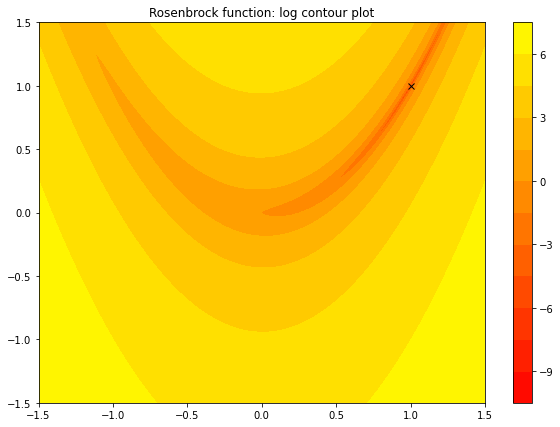

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Rosenbrock function
class rosenbrock_2d:
    
    def __init__(self):
        pass
        
    def f_value(self, x):
        return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2
    
    def gradient(self, x):    
        grad_x = -400*(x[1] - x[0]**2)*x[0] - 2*(1 - x[0])
        grad_y = 200*(x[1] - x[0]**2)
        return [grad_x, grad_y]
    
    def hessian(self, x):    
        hess_xx = -400*(x[1] - 3*x[0]**2) + 2
        hess_xy = -400*x[0]
        hess_yy = 200
        return [[hess_xx, hess_xy], [hess_xy, hess_yy]]
    
# Plot log of rosenbrock function
x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x, y)
Z = np.log(100*(Y - X**2)**2 + (1 - X)**2)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
cp = ax.contourf(X, Y, Z, 15, cmap=plt.get_cmap('autumn'))
plt.colorbar(cp)
ax.plot(1, 1, 'kx') 
ax.set_title('Rosenbrock function: log contour plot');

## Steepest descent

A descent direction is a vector $p \in \mathbb{R}^n$ for which a function $f$ decreases. From a Taylor series expansion, we have

\begin{align}
    f(x_k + \alpha p) &= f(x_k) + \alpha p^T \nabla f(x_k) + \frac{1}{2} \alpha^2 p^T \nabla^2 f(x_k + tp) p, \,\, t \in (0, \alpha) \notag \\
    &= f(x_k) + \alpha p^T \nabla f(x_k) + \mathcal{O}(\alpha^2)
\end{align}

with $p^T \nabla f(x_k) < 0$.

Therefore, for a small enough step size $\alpha > 0$, $f(x_k + \alpha p) < f(x_k)$ implies that

\begin{equation}
    p^T \nabla f(x_k) = \lVert p \rVert \lVert \nabla f(x_k) \rVert \cos \theta < 0
\end{equation}

where $\theta$ is the angle between $p$ and $\nabla f(x_k)$. This implies that $|\theta| > \frac{\pi}{2}$.

The steepest descent direction is the direction of most rapid decrease. It is the the solution to 

\begin{equation}
    \min_p p^T \nabla f(x_k), \,\,\, \text{subject to} \,\, \lVert p \rVert = 1.
\end{equation}

The solution is attained for $\cos \theta = - 1$. The steepest descent direction is the direction that moves along $p_k = - \nabla f(x_k)$ at every step $k$. Different methods exist to choose the step length $\alpha_k$. In this notebook, we will implement a backtracking line search approach satisfying the sufficient decrease condition while avoiding too small steps. The sufficient decrease condition, also called Armijo condition, is defined as 

\begin{equation}
    f(x_k + \alpha p_k) \leq f(x_k) + c_1 \alpha \nabla f(x_k)^T p_k
\end{equation}

for some constant $c_1 \in (0, 1)$. Starting with an initial step length $\tilde{\alpha} > 0$, backtracking line search iteratively multiplies the step length by a contraction factor $\rho \in (0, 1)$ until the sufficient decrease condition is satisfied.

Let's implement our functions (backtracking line search and steepest descent) and minimize the Rosenbrock function starting from an initial point $x_0 = [-1.2, 1]^T$.

Number of iterations: 902
Local minimum point: [0.99999806 0.99999612]
Function value at minimum: 0.0


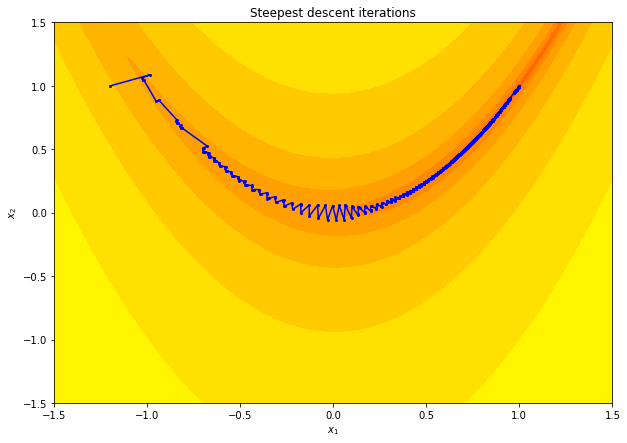

In [2]:
# Backtracking line search
def backtracking_line_search(x_k, p, alpha0, F, rho, c1):
    
    f_k = F.f_value(x_k)
    df_k = F.gradient(x_k)
    alpha = alpha0
    
    while F.f_value(x_k + alpha*p) > f_k + c1*alpha*np.dot(p, df_k):
        alpha = alpha*rho

    return alpha

# Steepest descent
def steepest_descent(F, ls, alpha0, x0, tol, max_iter):
    
    n_iter = 0
    x_k = x0
    stop_cond = False
    x_info = [x_k.copy()]
    
    while ~stop_cond and n_iter < max_iter:
        x_k_old = x_k.copy()
        p_k = -1*np.array(F.gradient(x_k)) 
        alpha_k = ls(x_k, p_k, alpha0)
        x_k += alpha_k * p_k
        x_info.append(x_k.copy())
        n_iter += 1
        
        norm_step = np.linalg.norm(x_k - x_k_old) / np.linalg.norm(x_k_old)
        stop_cond = (norm_step < tol)

    return x_k, x_info, n_iter

# Define parameters
F = rosenbrock_2d()
x0 = np.array([-1.2, 1])
alpha0 = 1
c1 = 1e-4
rho = 0.1
max_iter = 1e4
tol = 1e-8
ls = lambda x, p, alpha: backtracking_line_search(x, p, alpha, F=F, c1=c1, rho=rho)

# Optimization
xmin, x_info, n_iter = steepest_descent(F, ls, alpha0, x0, tol, max_iter)

# Plot steepest descent iterations
x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x, y)
Z = np.log(100*(Y - X**2)**2 + (1 - X)**2)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
cp = ax.contourf(X, Y, Z, 15, cmap=plt.get_cmap('autumn'))
ax.plot(np.array(x_info)[:,0], np.array(x_info)[:,1], color='b', marker='o', markersize=2)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Steepest descent iterations');

print('Number of iterations: ' + str(n_iter))
print('Local minimum point: ' + str(np.round(xmin, 8)))
print('Function value at minimum: ' + str(round(F.f_value(xmin), 8)))

## Newton's method

The Newton direction is found by considering the second order Taylor polynomial. Consider 

\begin{equation}
    f(x_k + p) \approx f(x_k) + p^T \nabla f(x_k) + \frac{1}{2} p^T \nabla^2 f(x_k)p := m_2(p)
\end{equation}

and assume that $\nabla^2 f(x_k)$ is positive semi-definite.

The Newton direction minimizes $m_2$. Setting

\begin{equation}
    m_2'(p) = \nabla^2 f(x_k)p + \nabla f(x_k) = 0
\end{equation}

yields 

\begin{equation}
    p = -\left(\nabla^2 f(x_k)\right)^{-1} \nabla f(x_k).
\end{equation}

The Newton direction is reliable if $m_2(p)$ is a close approximation to $f(x_k + p)$. Also, if $\nabla^2 f(x_k)$ is not positive semi-definite, the direction may not be defined (e.g., if $\nabla^2 f(x_k)$ is singular, its inverse does not exist). Newton's method converges faster than steepest descent. However, computation of the Hessian matrix is expensive.

The implementation of Newton's method is very similar to the steepest descent one. The difference is the computation of the direction $p_k$. Also, the initial value of $\alpha$ for the line search should be one for Newton's method.

Number of iterations: 48
Local minimum point: [1. 1.]
Function value at minimum: 0.0


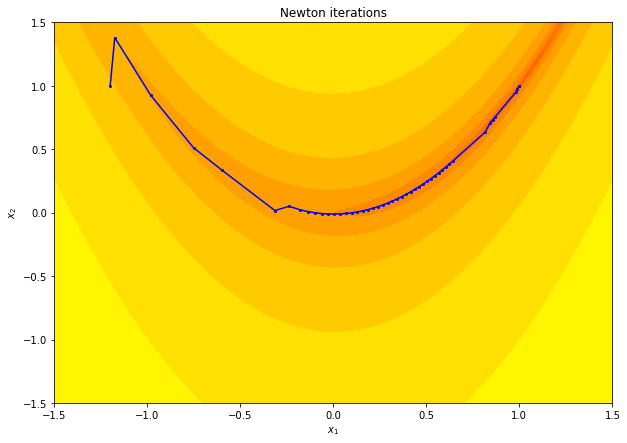

In [3]:
# Newton descent
def newton_descent(F, ls, alpha0, x0, tol, max_iter):
    
    n_iter = 0
    x_k = x0
    stop_cond = False
    x_info = [x_k.copy()]
    
    while ~stop_cond and n_iter < max_iter:
        x_k_old = x_k.copy()
        p_k = np.dot(-1*np.array(np.linalg.inv(F.hessian(x_k))), F.gradient(x_k))
        alpha_k = ls(x_k, p_k, alpha0)
        x_k += alpha_k * p_k
        x_info.append(x_k.copy())
        n_iter += 1
        
        norm_step = np.linalg.norm(x_k - x_k_old) / np.linalg.norm(x_k_old)
        stop_cond = (norm_step < tol)

    return x_k, x_info, n_iter

# Define parameters
F = rosenbrock_2d()
x0 = np.array([-1.2, 1])
alpha0 = 1
c1 = 1e-4
rho = 0.1
max_iter = 1e4
tol = 1e-8
ls = lambda x, p, alpha: backtracking_line_search(x, p, alpha, F=F, c1=c1, rho=rho)

# Optimization
xmin, x_info, n_iter = newton_descent(F, ls, alpha0, x0, tol, max_iter)

# Plot steepest descent iterations
x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 1.5, 500)
X, Y = np.meshgrid(x, y)
Z = np.log(100*(Y - X**2)**2 + (1 - X)**2)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
cp = ax.contourf(X, Y, Z, 15, cmap=plt.get_cmap('autumn'))
ax.plot(np.array(x_info)[:,0], np.array(x_info)[:,1], color='b', marker='o', markersize=2)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Newton iterations');

print('Number of iterations: ' + str(n_iter))
print('Local minimum point: ' + str(np.round(xmin, 8)))
print('Function value at minimum: ' + str(round(F.f_value(xmin), 8)))